## Offline Reinforcement Learning (ORL): Conservative Q-Learning (CQL) in Pendulum

离线学习

In [13]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([0.596989  , 0.80224943, 0.11488384], dtype=float32)

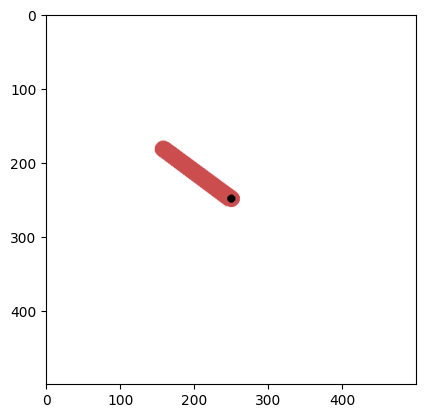

In [14]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

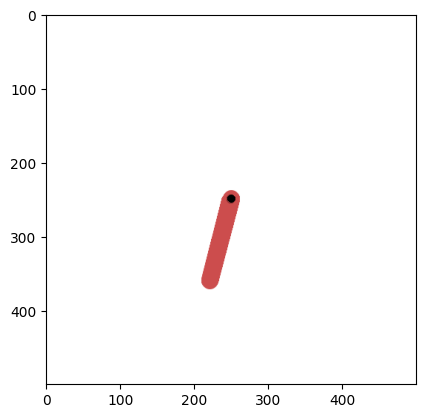

(1.3682923316955566, -1411.7758811389342)

In [15]:
import torch
import random
from IPython import display
import math

# 基底模型使用SAC
class SAC:
	class ModelAction(torch.nn.Module):
		def __init__(self):
			super().__init__()
			# 定义模型
			self.fc_state = torch.nn.Sequential(
				torch.nn.Linear(3, 128),
				torch.nn.ReLU(),
			)

			self.fc_mu = torch.nn.Linear(128, 1)
			self.fc_std = torch.nn.Sequential(
				torch.nn.Linear(128, 1),
				torch.nn.Softplus(),
			)

		def forward(self, state):
			# [b, 3] -> [b, 128]
			state = self.fc_state(state)

			# [b, 128] -> [b, 1]
			mu = self.fc_mu(state)

			# [b, 128] -> [b, 1]
			std = self.fc_std(state)

			# 定义b个正态分布
			dist = torch.distributions.Normal(mu, std)

			# 采样b个样本
      # 这里用的是rsample,表示重采样,
      # 其实就是先从一个标准正态分布中采样,然后乘以标准差,加上均值
			sample = dist.rsample()

			# 样本压缩到-1， 1，求动作
			action = torch.tanh(sample)

			# 求概率对数
			log_prob = dist.log_prob(sample)
  
			# 动作熵
			entropy = log_prob - (1 - action.tanh() ** 2 + 1e-7).log()
			entropy = -entropy

			return action * 2, entropy

	class ModelValue(torch.nn.Module):
		
		def __init__(self):
			super().__init__()
			self.sequential = torch.nn.Sequential(
			torch.nn.Linear(4, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 1),
		)
    
		def forward(self, state, action):
			# [b, 3 + 1] -> [b, 4]
			state = torch.cat([state, action], dim=1)

			# [b, 4] -> [b, 1]
			return self.sequential(state)
  
	def __init__(self):
		self.model_action = self.ModelAction()
  
		self.model_value1 = self.ModelValue()
		self.model_value2 = self.ModelValue()

		self.model_value_next1 = self.ModelValue()
		self.model_value_next2 = self.ModelValue()

		self.model_value_next1.load_state_dict(self.model_value1.state_dict())
		self.model_value_next2.load_state_dict(self.model_value2.state_dict())

		# alpha 可学习参数
		self.alpha = torch.tensor(math.log(0.01))
		self.alpha.requires_grad = True
  
		self.optimizer_action = torch.optim.Adam(self.model_action.parameters(), lr=3e-4)
		self.optimizer_value1 = torch.optim.Adam(self.model_value1.parameters(), lr=3e-3)
		self.optimizer_value2 = torch.optim.Adam(self.model_value2.parameters(), lr=3e-3)
		self.optimizer_alpha = torch.optim.Adam([self.alpha], lr=3e-4)

		self.loss_fn = torch.nn.MSELoss()
  
	def get_action(self, state):
		# 走神经网络，得到一个动作
		state = torch.FloatTensor(state).reshape(1, 3)
		# action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]
		action, _ = self.model_action(state)
		return action.item()

	def test(self, play):
		#初始化游戏
		state = env.reset()
		
		#记录反馈值的和,这个值越大越好
		reward_sum = 0
		
		#玩到游戏结束为止
		over = False
		while not over:
			#根据当前状态得到一个动作
			action = self.get_action(state)
			
			#执行动作,得到反馈
			state, reward, over, _ = env.step([action])
			reward_sum += reward
			
			# 打印动画
			if play and random.random() < 0.2: # 跳帧
				display.clear_output(wait=True)
				show()
				
		return reward_sum

	def _soft_update(self, model, model_next):
		for param, param_next in zip(model.parameters(), model_next.parameters()):
			# 小比例更新
			value = param_next.data * 0.995 + param.data * 0.005
			param_next.data.copy_(value)

	def _get_target(self, reward, next_state, over):
		# 首先使用model_action计算动作和动作的熵
		# [b, 3] -> [b, 1], [b, 1]
		action, entropy = self.model_action(next_state)

		# 评估next_state的价值
		# [b, 4], [b, 1] -> [b, 1]
		target1 = self.model_value_next1(next_state, action)
		target2 = self.model_value_next2(next_state, action)

		# 取价值小的，出于稳定性
		# [b, 1]
		target = torch.min(target1, target2)

		# 还原alpha
		# target 加上动作熵，alpha作为权重系数
		# [b, 1] - [b, 1] -> [b, 1]
		target += self.alpha.exp() * entropy

		# [b, 1] 
		target *= 0.99
		target *= (1 - over)
		target += reward

		return target

	def _get_loss_action(self, state):
		# 计算action和熵
		# [b, 3] -> [b, 1], [b, 1]
		action, entropy = self.model_action(state)

		# 使用两个value网络评估action的价值
		#[b, 3],[b, 1] -> [b, 1]
		value1 = self.model_value1(state, action)
		value2 = self.model_value2(state, action)

		# 取价值小的,出于稳定性考虑
		# [b, 1]
		value = torch.min(value1, value2)

		# alpha还原后乘以熵,这个值期望的是越大越好,但是这里是计算loss,所以符号取反
		# [1] - [b, 1] -> [b, 1]
		loss_action = -self.alpha.exp() * entropy
		
		# 减去value,所以value越大越好,这样loss就会越小
		loss_action -= value

		return loss_action.mean(), entropy

	def _get_loss_value(self, model_value, target, state, action, next_state):
		# 计算value
		value = model_value(state, action)
  
		# 计算loss, value, 贴近target
		loss_value = self.loss_fn(value, target)
		return loss_value

	def train(self, state, reward, action, next_state, over):
		# 对reward 偏移，便于训练
		reward = (reward + 8) / 8

		# 计算value和target, target已经考虑了动作和熵
		# [b, 1]
		target = self._get_target(reward, next_state, over)
		target = target.detach()
		
		# 计算两个value
		loss_value1 = self._get_loss_value(self.model_value1, target, state, action, next_state)
		loss_value2 = self._get_loss_value(self.model_value2, target, state, action, next_state)
		
		# 更新参数
		self.optimizer_value1.zero_grad()
		loss_value1.backward()
		self.optimizer_value1.step()
		
		self.optimizer_value2.zero_grad()
		loss_value2.backward()
		self.optimizer_value2.step()
		
		# 使用model_value计算model_action的loss, 更新参数
		loss_action, entropy = self._get_loss_action(state)
		self.optimizer_action.zero_grad()
		loss_action.backward()
		self.optimizer_action.step()
		
		# 熵乘以alpha就是alpha的loss
		# [b, 1] -> [1]
		loss_alpha = (entropy + 1).detach() * self.alpha.exp()
		loss_alpha = loss_alpha.mean()
		
		# 更新alpha值
		self.optimizer_alpha.zero_grad()
		loss_alpha.backward()
		self.optimizer_alpha.step()
		
		# 小比例更新
		self._soft_update(self.model_value1, self.model_value_next1)
		self._soft_update(self.model_value2, self.model_value_next2)

teacher = SAC()

teacher.train(
	torch.randn(5, 3),
	torch.randn(5, 1),
	torch.randn(5, 1),
	torch.randn(5, 3),
	torch.zeros(5, 1).long(),
)

teacher.get_action([1, 2, 3]), teacher.test(play=True)

In [16]:
class Data:
	def __init__(self):
		# 样本池
		self.datas = []
  
	# 向样本池中添加N条数据,删除M条最古老的数据
	def update_data(self, agent):
		# 初始化游戏
		state = env.reset()
		
		# 玩到游戏结束为止
		over = False
		while not over:
			# 根据当前状态得到一个动作
			action = agent.get_action(state)
			
			# 执行动作，得到反馈
			next_state, reward, over, _ = env.step([action])
			
			# 记录数据样本
			self.datas.append((state, action, reward, next_state, over))
			
			# 更新游戏状态，开始下一个动作
			state = next_state

		# 数据上限，超出时从最古老的开始删除
		while len(self.datas) > 100000:
			self.datas.pop(0)
  
  # 获取一批数据样本
	def get_sample(self):
		# 从样本池中采样
		samples = random.sample(self.datas, 64)
  
		# [b, 3]
		state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
		# [b, 1]
		reward = torch.FloatTensor([i[1] for i in samples]).reshape(-1, 1)
		# [b, 1]
		action = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
		# [b, 4]
		next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
		# [b, 1]
		over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)
		
		return state, action, reward,  next_state, over

data = Data()

data.update_data(teacher), data.get_sample()


(None,
 (tensor([[-0.9836,  0.1806, -0.8154],
          [-0.9619,  0.2733, -0.5198],
          [-0.9739,  0.2268,  2.4111],
          [-0.7402, -0.6724,  2.0265],
          [-0.9979, -0.0644,  1.0891],
          [-0.9948, -0.1021, -0.5214],
          [-0.9811, -0.1933, -0.6799],
          [-0.9639, -0.2662, -1.1421],
          [-0.9312, -0.3645, -0.5167],
          [-0.6624, -0.7491,  0.0440],
          [-0.9016,  0.4326, -2.2272],
          [-0.9598, -0.2807,  2.4436],
          [-0.9817, -0.1907, -1.0553],
          [-0.9356,  0.3531, -0.5079],
          [-0.9755, -0.2202,  0.8817],
          [-0.7224, -0.6914, -2.3451],
          [-0.6944, -0.7196,  1.3150],
          [-0.7892,  0.6142,  1.4013],
          [-0.4627, -0.8865, -0.0950],
          [-0.9833, -0.1819,  1.8842],
          [-0.5054,  0.8629, -0.9781],
          [-0.5572, -0.8304, -3.0944],
          [-0.9124, -0.4093, -0.1507],
          [-0.9872,  0.1593,  0.7656],
          [-0.9407,  0.3394, -0.5435],
          [-0.9215

In [17]:
for epoch in range(100):
  # 更新N条数据
  data.update_data(teacher)
  
  #每次更新过数据后,学习N次
  for i in range(200):
    teacher.train(*data.get_sample())
  
  if epoch % 10 == 0:
    test_result = sum([teacher.test(play=False) for _ in range(10)]) / 10
    print(epoch, test_result)

0 -1548.938018236178
10 -1309.710395476617
20 -265.0156588538357
30 -220.45109453692083
40 -128.79973327033377
50 -208.51339735495793
60 -125.69493989083094
70 -100.9542514082656
80 -155.65323435222143
90 -220.43637117480694


In [18]:
class CQL(SAC):
	def __init__(self):
		super().__init__()
  
	def _get_loss_value(self, model_value, target, state, action, next_state):
		# 计算value
		value = model_value(state, action)
  
		# 计算loss, value的目标要贴近target
		loss_value = self.loss_fn(value, target)
		"""CQL 部分"""

		# state 复制5遍
		# [b, 3] -> [b, 1, 3] -> [b, 5, 3]
		state = state.unsqueeze(dim=1)
		# [b, 1, 3] -> [b, 5, 3] -> [b * 5, 3]
		state = state.repeat(1, 5, 1).reshape(-1, 3)
  
		# next_state 复制5遍
		# [b, 3] -> [b, 1, 3]
		next_state = next_state.unsqueeze(dim=1)
		# [b, 1, 3] -> [b, 5, 3] -> [b * 5, 3]
		next_state = next_state.repeat(1, 5, 1).reshape(-1, 3)
  
		# 随机一批动作,数量是数据量的5倍,值域在-1到1之间
		rand_action = torch.empty([len(state), 1]).uniform_(-1, 1)
  
		# 计算state的动作和熵
		# [b*5, 3] -> [b * 5, 1], [b * 5, 1]
		curr_action, curr_entropy = self.model_action(state)
  
		# 计算next_state的动作和熵
		# [b*5, 3] -> [b * 5, 1], [b * 5, 1]
		next_action, next_entropy = self.model_action(next_state)
  
		# 计算三份动作分别的value
		# [b*5, 1],[b*5, 1] -> [b*5, 1] -> [b, 5, 1]
		value_rand = model_value(state, rand_action).reshape(-1, 5, 1)
		# [b*5, 1],[b*5, 1] -> [b*5, 1] -> [b, 5, 1]
		value_curr = model_value(state, curr_action).reshape(-1, 5, 1)
		# [b*5, 1],[b*5, 1] -> [b*5, 1] -> [b, 5, 1]
		value_next = model_value(state, next_action).reshape(-1, 5, 1)
  
		# [b*5, 1] -> [b, 5, 1]
		curr_entropy = curr_entropy.detach().reshape(-1, 5, 1)
		next_entropy = next_entropy.detach().reshape(-1, 5, 1)
  
		# 三份分别减去熵
		# [b, 5, 1]
		value_rand -= math.log(0.5)
		# [b, 5, 1]
		value_curr -= curr_entropy
		# [b, 5, 1]
		value_next -= next_entropy
  
		# 拼合三份value
		# [b, 5+5+5, 1] -> [b, 15, 1]
		value_cat = torch.cat([value_rand, value_curr, value_next], dim=1)
  
		# 等价t.logsumexp(dim=1), t.exp().sum(dim=1).log()
		# [b, 15, 1] -> [b, 1] -> scala
		loss_cat = torch.logsumexp(value_cat, dim=1).mean()
  
		# 原本loss增加这一部分
		# scala
		loss_value += 5.0 * (loss_cat - value.mean())
		"""CQL ends"""
		return loss_value

student = CQL()

student.train(
	torch.randn(5, 3),
	torch.randn(5, 1),
	torch.randn(5, 1),
	torch.randn(5, 3),
	torch.zeros(5, 1).long(),
)
  
student.get_action([1, 2, 3]), student.test(play=False)
  

(-0.3126147985458374, -1283.2853357252193)

In [19]:
# 训练N次，不需要重新更新数据
for i in range(50000):
  # 采样一批数据
  student.train(*data.get_sample())
  
  if i % 2000 == 0:
    test_result = sum([student.test(play=False) for _ in range(10)]) / 10
    print(i, test_result)

0 -1325.7365422385617
2000 -652.3086231400446
4000 -1183.3190932277416
6000 -1216.7510548453006
8000 -1117.4078472496203
10000 -1084.1047110378972
12000 -933.695415529582
14000 -1022.9378256066586
16000 -675.4496008432926
18000 -1101.8670160992338
20000 -826.2519452406996
22000 -869.5249407195382
24000 -786.5408740633502
26000 -915.6305196224314
28000 -747.3215729372055
30000 -641.8884123844629
32000 -506.96895209455613
34000 -873.0871132112474
36000 -990.0316392945861
38000 -883.0756493114055
40000 -563.6339445074582
42000 -1054.3843498753818
44000 -823.7093834226282
46000 -401.15891767260473
48000 -1052.0057140297176


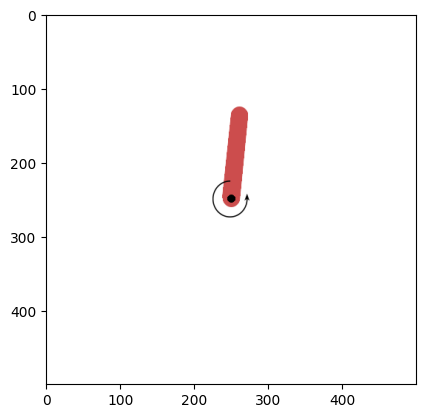

-264.3019416079112

In [23]:
student.test(play=True)